<a href="https://colab.research.google.com/github/lmcanavals/machine_learning/blob/main/1201_not_so_small_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
from torch.nn.modules.activation import LeakyReLU

torch.manual_seed(42)

### Important

as an example we create a data loader using pytorch mnist dataset, wi won't use it and will use instead a 8x8 smaller dataset in hope of shorter training times for the example

100%|██████████| 26421880/26421880 [00:02<00:00, 11143749.03it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 177666.08it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3302244.39it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 13691995.56it/s]


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


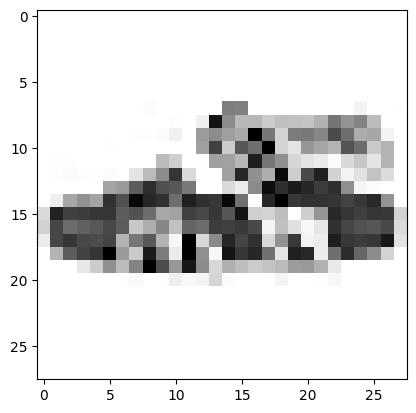

Label: 5


In [3]:
from torchvision.datasets import FashionMNIST

n = 28

dataloader = DataLoader(FashionMNIST('.', download=True, transform=transforms.ToTensor()),
                        batch_size=64, shuffle=True)
train_features, train_labels = next(iter(dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap='gray_r')
plt.show()
print(f"Label: {label}")

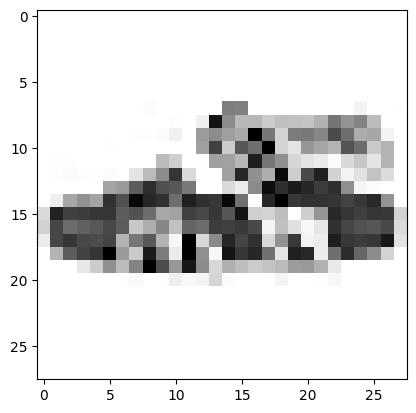

Label: 5


In [4]:
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap='gray_r')
plt.show()
print(f"Label: {label}")

## View a grid of 5x5 digits

In [5]:
def show_tensor_image(image_tensor, num_images=25, size=(1, n, n)):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

## The Generator

### Generator block

In [6]:
def get_generator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True)
    )

### Class Generator

In [7]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_dim=n*n, hidden_dim=128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim*2),
            get_generator_block(hidden_dim*2, hidden_dim*4),
            get_generator_block(hidden_dim*4, hidden_dim*8),
            nn.Linear(hidden_dim*8, im_dim),
            nn.Sigmoid()
        )

    def forward(self, noise):
        return self.gen(noise)

    def get_gen(self):
        return self.gen

In [8]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

## The Discriminator

In [9]:
def get_discriminator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(0.2, inplace=True)
    )

In [10]:
class Discriminator(nn.Module):
    def __init__(self, im_dim=n*n, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim*4),
            get_discriminator_block(hidden_dim*4, hidden_dim*2),
            get_discriminator_block(hidden_dim*2, hidden_dim),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, image):
        return self.disc(image)

    def get_disc(self):
        return self.disc

## Training

In [11]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.00001
device = 'cuda'

In [12]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [13]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss) / 2
    return disc_loss

In [14]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    return gen_loss

In [15]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True
gen_loss = False
error = False

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch   0 Step  500 Generator Loss: 1.01026012802124 Discriminator Loss: 0.5394824277758601


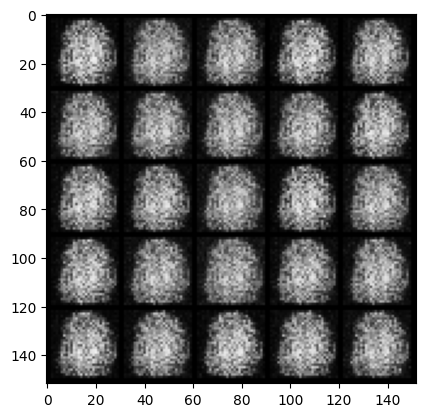

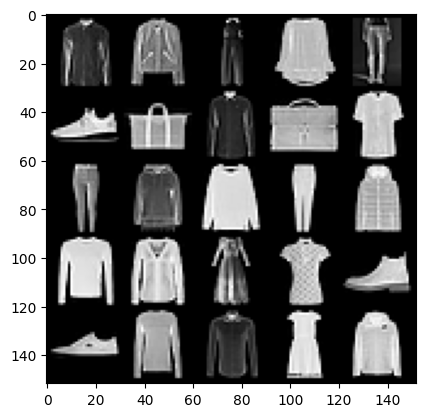

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch   1 Step 1000 Generator Loss: 1.3174131996631628 Discriminator Loss: 0.36764325869083414


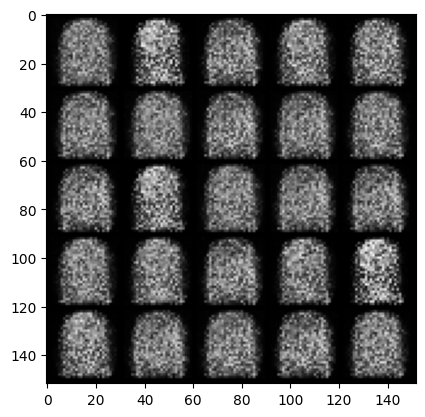

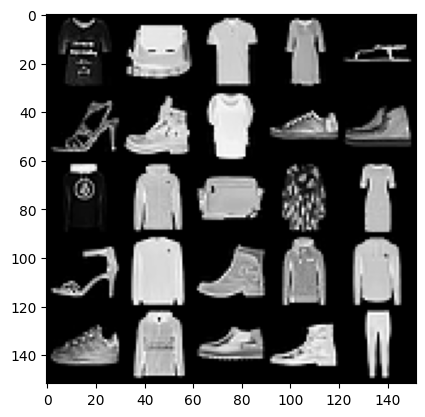

Epoch   1 Step 1500 Generator Loss: 1.1717068264484405 Discriminator Loss: 0.4330692202448844


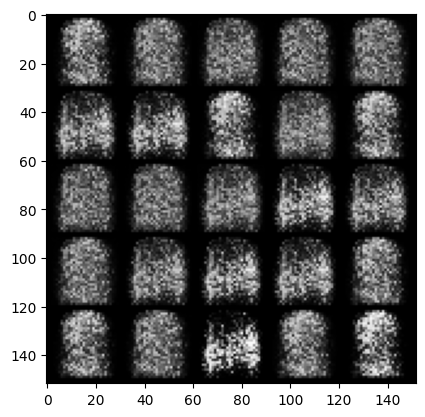

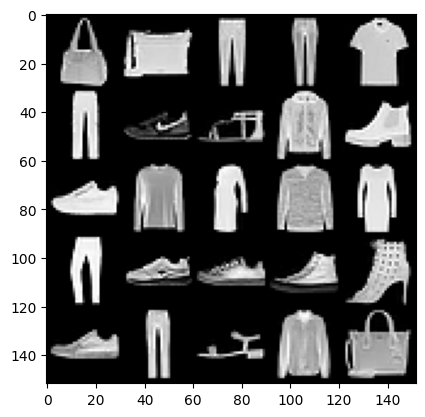

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch   2 Step 2000 Generator Loss: 1.2273041388988493 Discriminator Loss: 0.37274956452846486


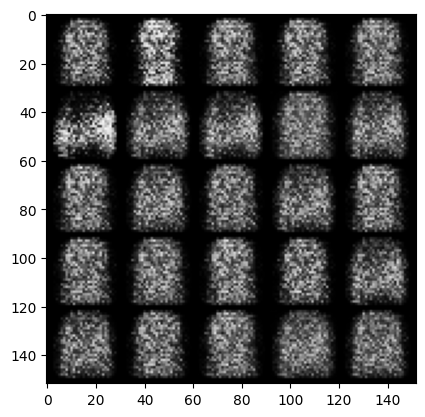

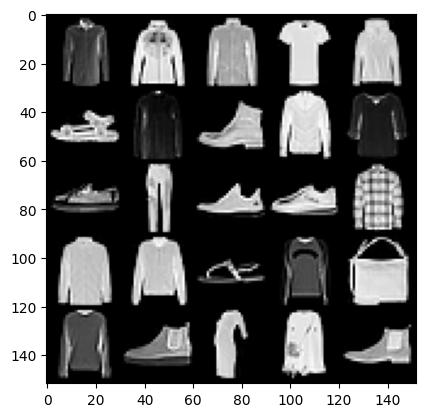

Epoch   2 Step 2500 Generator Loss: 1.4042419855594614 Discriminator Loss: 0.3357080749273301


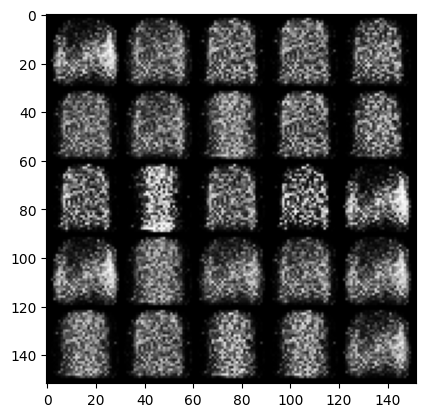

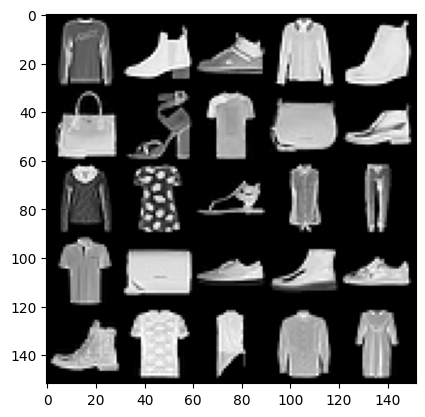

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch   3 Step 3000 Generator Loss: 1.3982538843154915 Discriminator Loss: 0.37344732481241255


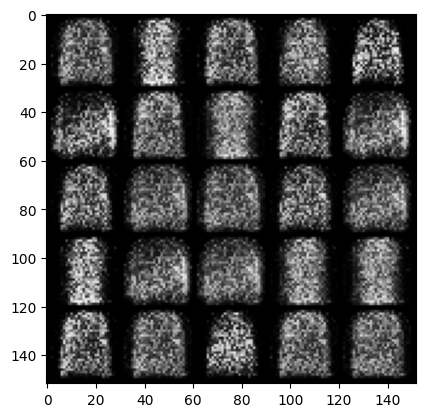

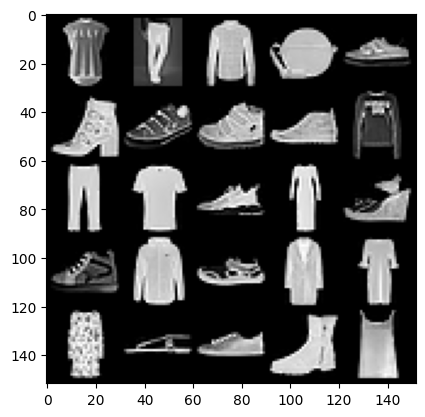

Epoch   3 Step 3500 Generator Loss: 1.4651219480037703 Discriminator Loss: 0.3866803575158123


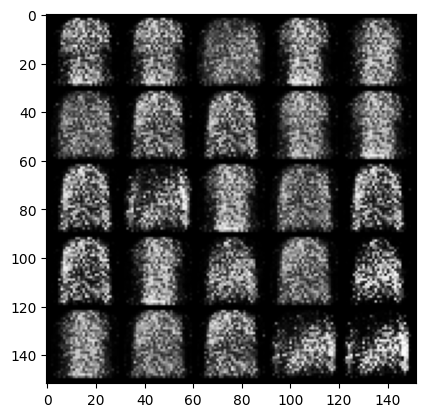

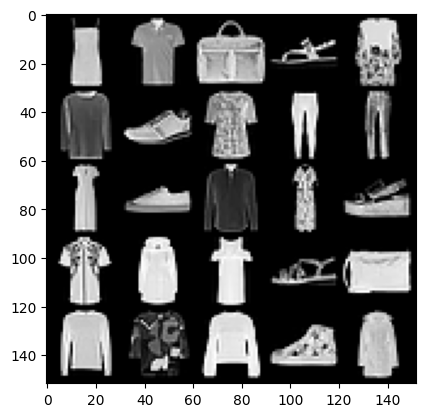

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch   4 Step 4000 Generator Loss: 1.513362974882126 Discriminator Loss: 0.37474603796005246


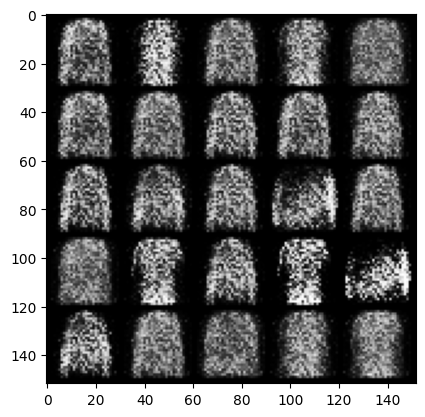

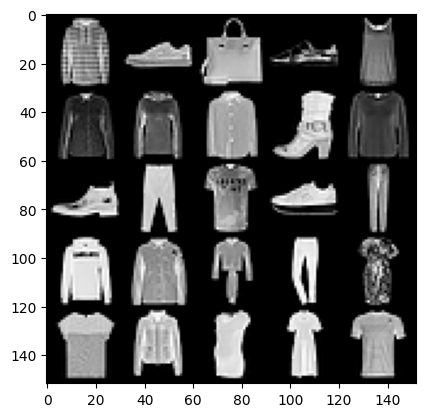

Epoch   4 Step 4500 Generator Loss: 1.6610380523204804 Discriminator Loss: 0.3400023312568664


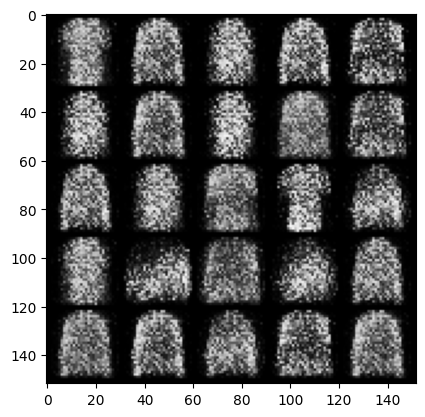

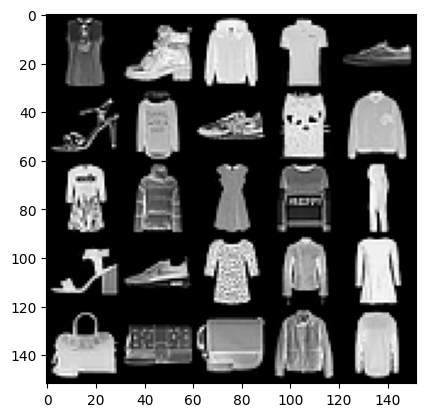

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch   5 Step 5000 Generator Loss: 1.709984075307847 Discriminator Loss: 0.33073511153459534


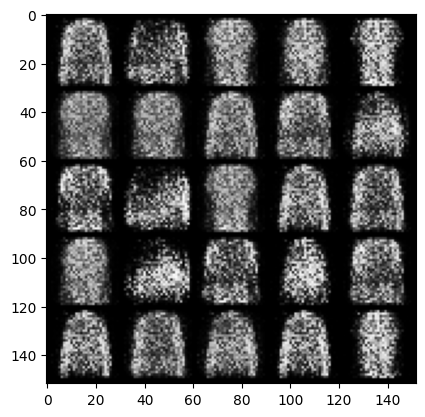

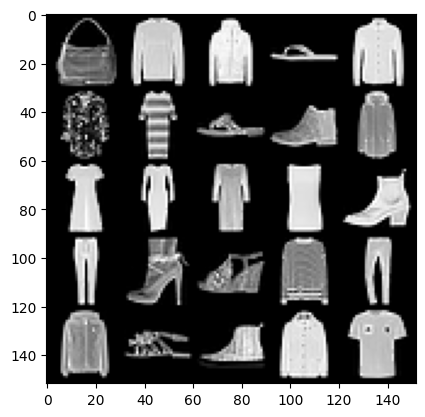

Epoch   5 Step 5500 Generator Loss: 1.8402886450290663 Discriminator Loss: 0.30666203707456635


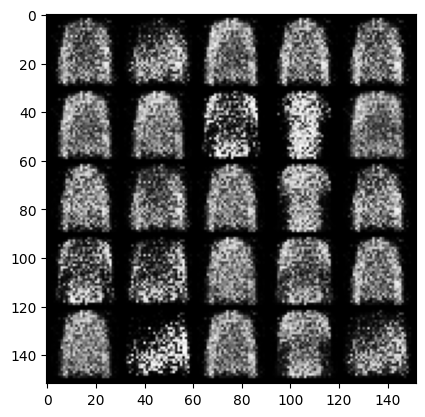

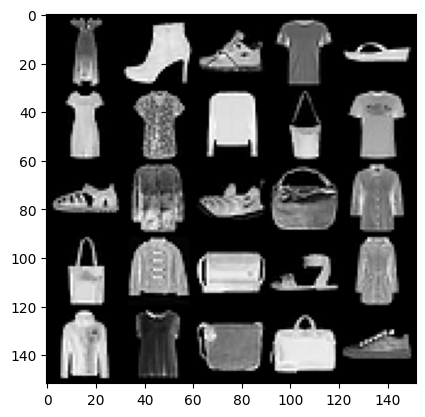

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch   6 Step 6000 Generator Loss: 1.8628953778743749 Discriminator Loss: 0.28241818451881395


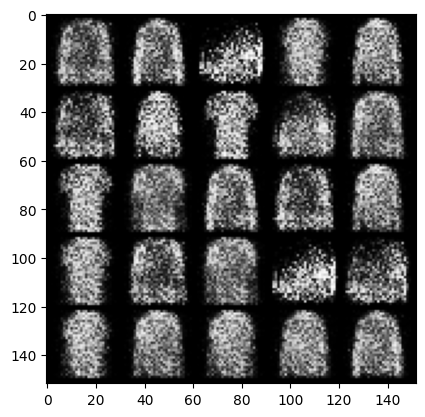

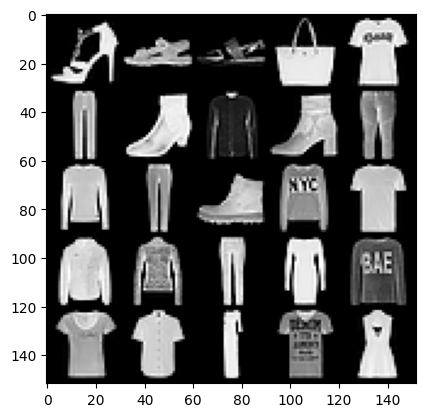

Epoch   6 Step 6500 Generator Loss: 1.8826765460968016 Discriminator Loss: 0.28233557313680674


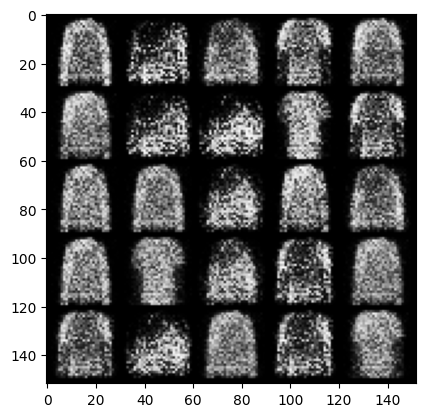

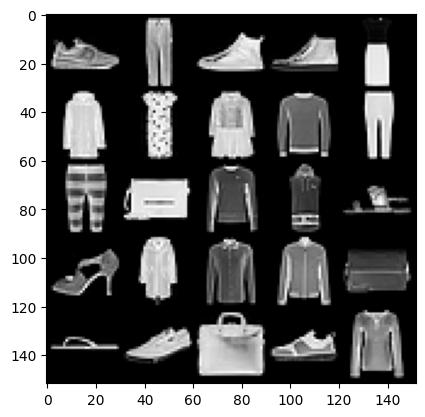

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch   7 Step 7000 Generator Loss: 1.86268113899231 Discriminator Loss: 0.3073021363019946


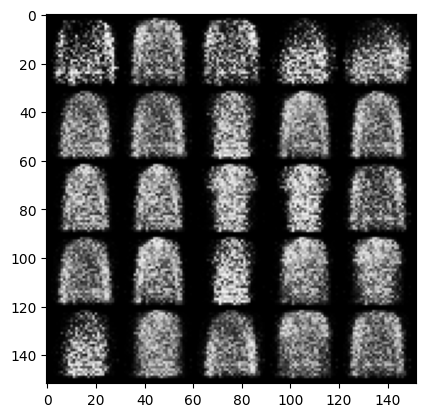

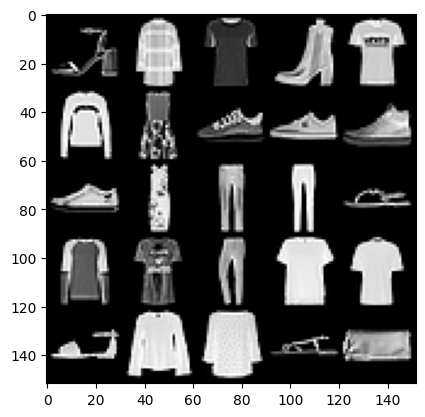

Epoch   7 Step 7500 Generator Loss: 1.7097909669876104 Discriminator Loss: 0.34219700589776025


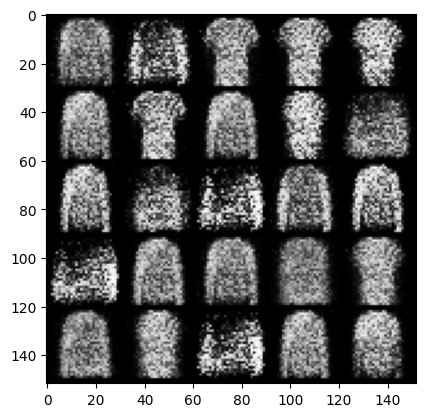

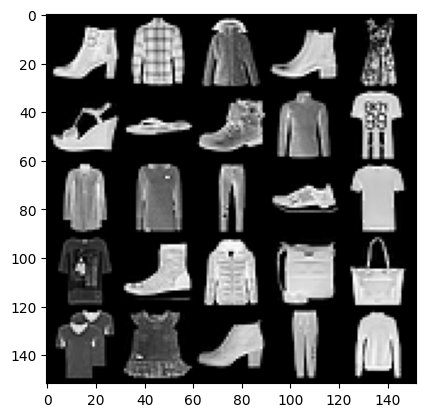

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch   8 Step 8000 Generator Loss: 1.6672987916469562 Discriminator Loss: 0.3638777084946632


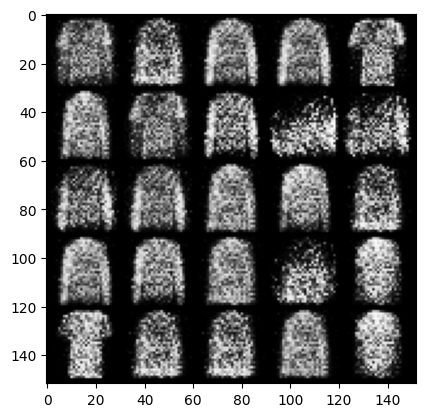

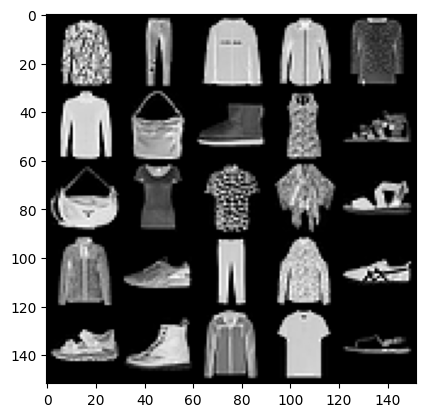

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch   9 Step 8500 Generator Loss: 1.6950902278423294 Discriminator Loss: 0.3430169364809992


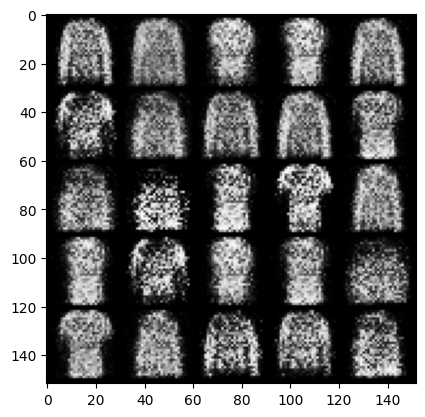

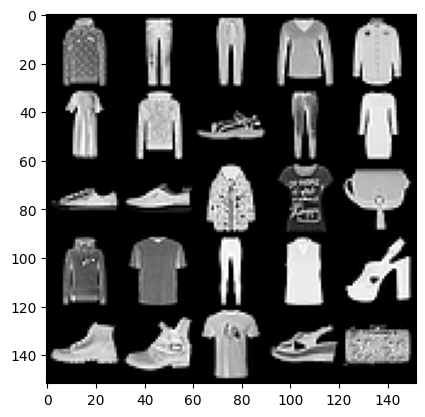

Epoch   9 Step 9000 Generator Loss: 1.707800590753556 Discriminator Loss: 0.35047482502460475


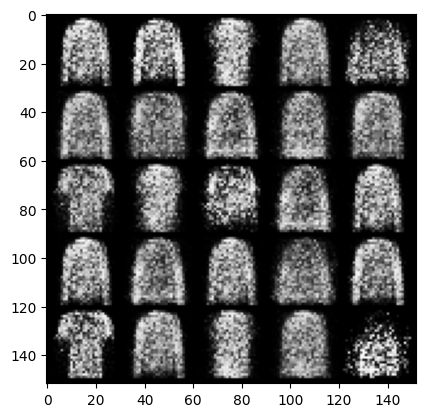

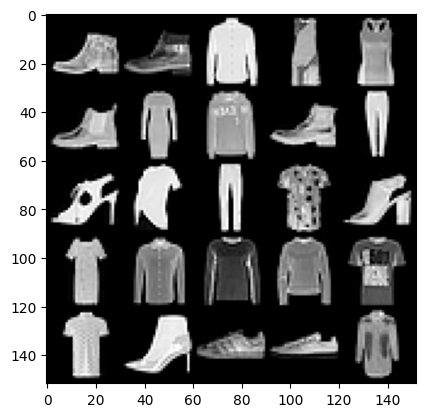

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch  10 Step 9500 Generator Loss: 1.6741675245761862 Discriminator Loss: 0.3710672797560688


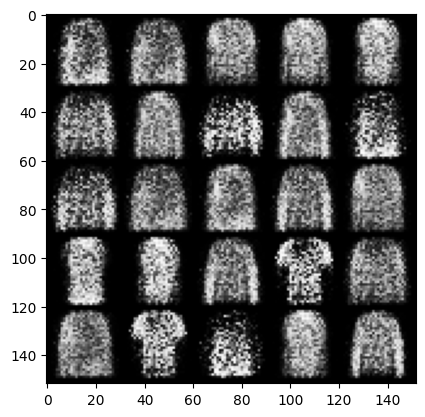

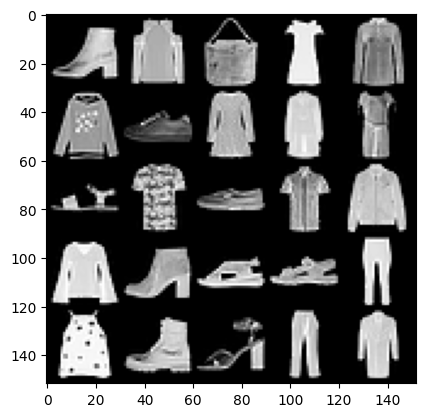

Epoch  10 Step 10000 Generator Loss: 1.6778530535697922 Discriminator Loss: 0.3660561327338223


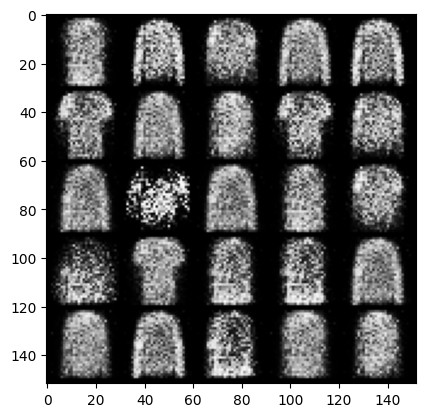

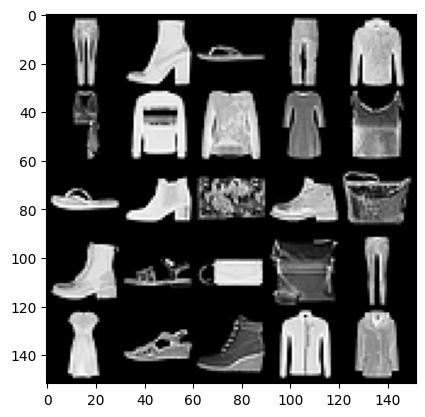

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch  11 Step 10500 Generator Loss: 1.6504109330177297 Discriminator Loss: 0.3579515575766564


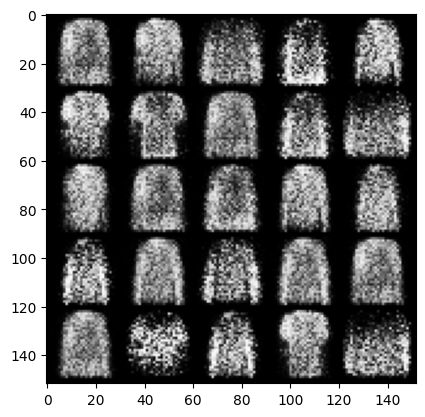

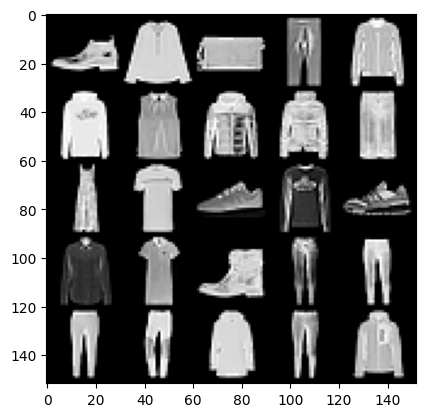

Epoch  11 Step 11000 Generator Loss: 1.6253380627632146 Discriminator Loss: 0.38629478204250317


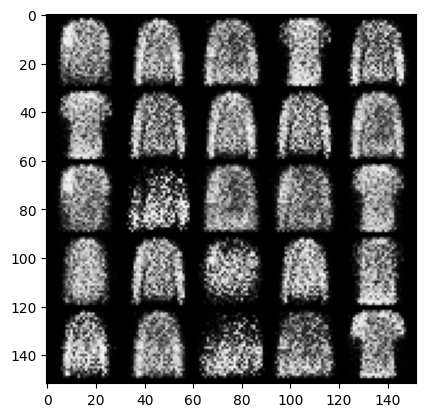

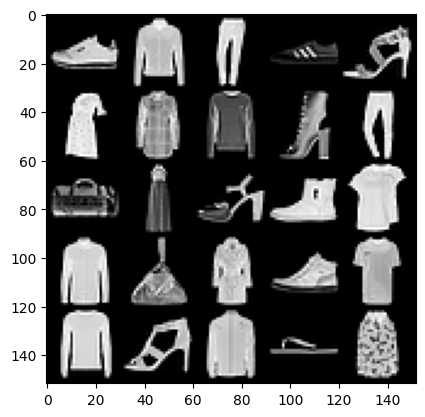

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch  12 Step 11500 Generator Loss: 1.5737157161235815 Discriminator Loss: 0.389316272497177


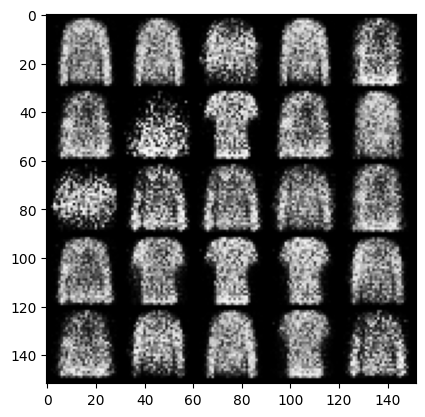

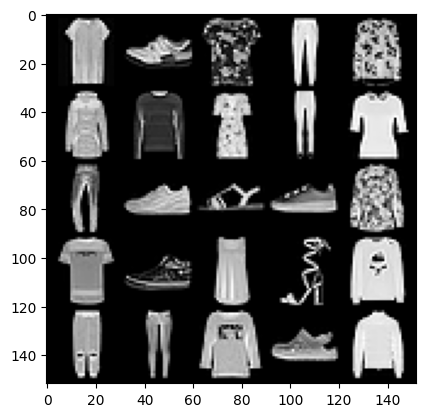

Epoch  12 Step 12000 Generator Loss: 1.5376057698726655 Discriminator Loss: 0.4060723809599877


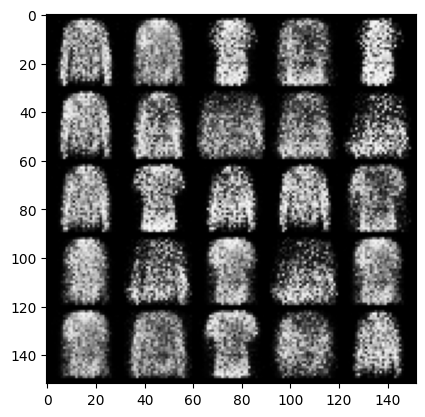

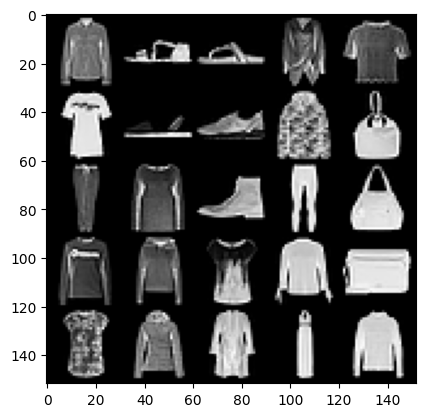

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch  13 Step 12500 Generator Loss: 1.5280270137786869 Discriminator Loss: 0.40579203051328677


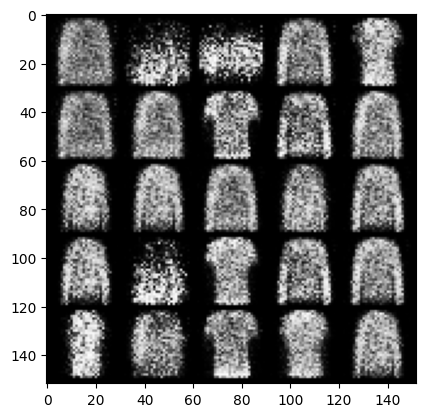

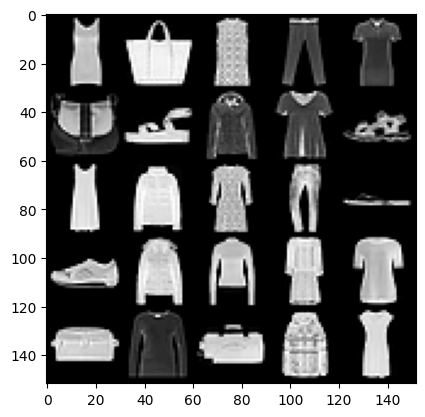

Epoch  13 Step 13000 Generator Loss: 1.4665292725563073 Discriminator Loss: 0.4156217265725136


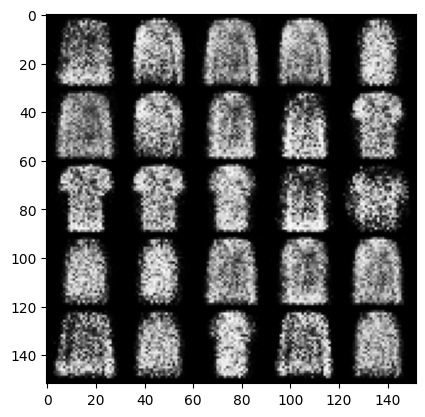

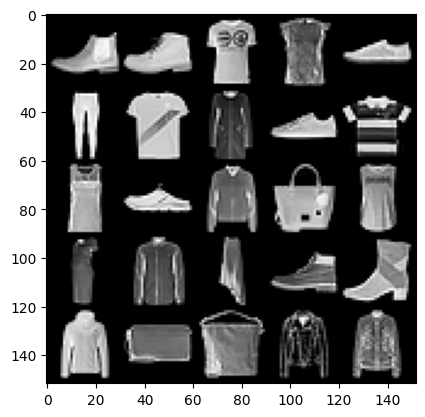

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch  14 Step 13500 Generator Loss: 1.4591104774475079 Discriminator Loss: 0.4249797380566597


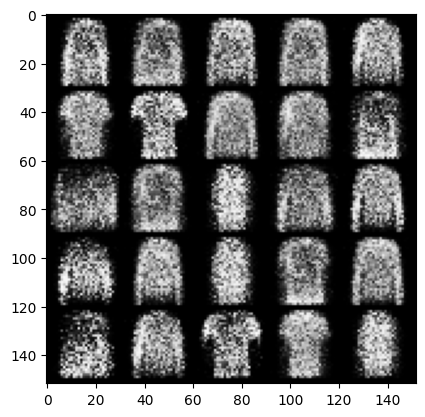

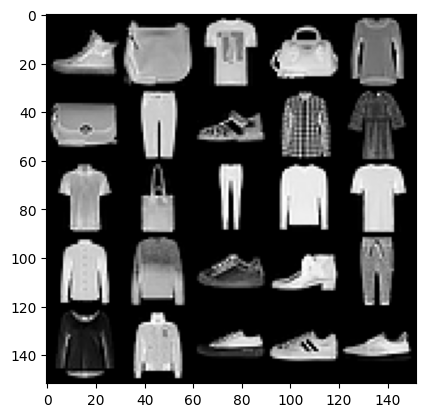

In [ ]:
old_generator_weights = None
for epoch in range(n_epochs):
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.view(cur_batch_size, -1).to(device)
        disc_opt.zero_grad()
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)
        disc_loss.backward(retain_graph=True)
        disc_opt.step()

        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()

        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward()
        gen_opt.step()

        if test_generator:
            try:
                assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
            except:
                error = True
                print("Failure runtime stuff")

        mean_discriminator_loss += disc_loss.item() / display_step
        mean_generator_loss += gen_loss.item() / display_step

        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Epoch {epoch:3} Step {cur_step:4} Generator Loss: {mean_generator_loss} Discriminator Loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            show_tensor_image(fake)
            show_tensor_image(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0

        cur_step += 1

## Conclussion

### Fake images

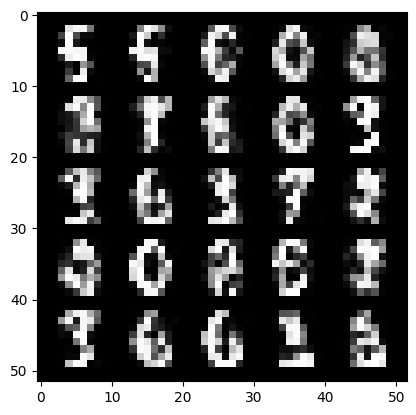

In [ ]:
noise = get_noise(25, z_dim, device)
fake = gen(noise)
show_tensor_image(fake)

In [ ]:
disc(fake)

tensor([[ 0.9390],
        [ 0.3692],
        [-0.9126],
        [-0.7464],
        [-0.3570],
        [-0.2078],
        [ 0.0601],
        [-0.6439],
        [-0.9034],
        [-0.1356],
        [-0.5760],
        [ 0.0210],
        [-0.3723],
        [ 0.4737],
        [-0.5999],
        [-0.3554],
        [-0.3610],
        [-0.2484],
        [-0.6178],
        [-0.4514],
        [-0.1884],
        [ 0.2737],
        [-0.0474],
        [ 0.1004],
        [ 0.2193]], device='cuda:0', grad_fn=<AddmmBackward0>)

### Real ones

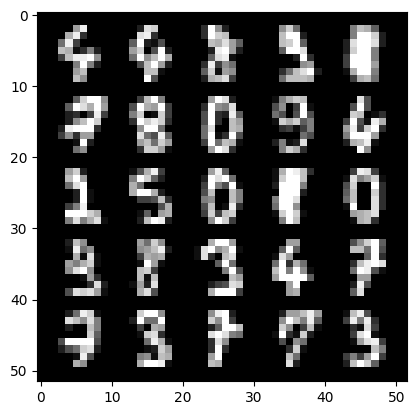

In [ ]:
for real, _ in dataloader:
    show_tensor_image(real)
    break